<a href="https://colab.research.google.com/github/athens-igg/dfu-models/blob/main/mobilenet_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()   # select kaggle.json

Saving kaggle (13).json to kaggle (13).json


{'kaggle (13).json': b'{"username":"athenkaggle","key":"d32d4c92295beb283da6f9562c46f543"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle (13).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 1.67GB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:


!unzip -q dfu-wagners-classification.zip -d /content/drive

In [ ]:

train_data="/content/drive/Dataset/Training"
valid_data="/content/drive/Dataset/Validation"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
N_CLASSES = 5   # Wagner 0–4 (adjust if you have normal + ulcer separately)

# ============================
# 1) Data Preprocessing & Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_data,  # path to training dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    valid_data,  # path to validation dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
# ============================
# 2) Define MobileNetV2 Model
# ============================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model for transfer learning
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(N_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================
# 3) Compile
# ============================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 4) Callbacks
# ============================
checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_model.h5",
    monitor="val_loss",   # or "val_loss" if you prefer
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1),
    checkpoint
]


# ============================
# 5) Train
# ============================
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# ============================
# 6) Fine-tune (optional)
# ============================
# Unfreeze some top layers
base_model.trainable = True
for layer in base_model.layers[:-30]:  # keep earlier layers frozen
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)


Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.5285 - loss: 1.3282

31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5327 - loss: 1.3171 - val_accuracy: 0.6034 - val_loss: 0.9606 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8123 - loss: 0.5415

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.8126 - loss: 0.5404 - val_accuracy: 0.7328 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8368 - loss: 0.4539

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.8368 - loss: 0.4530 - val_accuracy: 0.7414 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8672 - loss: 0.3739

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.8674 - loss: 0.3733 - val_accuracy: 0.8362 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8826 - loss: 0.3286

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.8823 - loss: 0.3290 - val_accuracy: 0.8534 - val_loss: 0.4557 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8757 - loss: 0.3555

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.8762 - loss: 0.3541 - val_accuracy: 0.8793 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - accuracy: 0.8870 - loss: 0.2922 - val_accuracy: 0.8362 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8974 - loss: 0.2703

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.8974 - loss: 0.2703 - val_accuracy: 0.8621 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9184 - loss: 0.2668

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.9180 - loss: 0.2674 - val_accuracy: 0.8793 - val_loss: 0.3342 - learning_rate: 0.0010
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.9139 - loss: 0.2311 - val_accuracy: 0.8966 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9144 - loss: 0.2501 - val_accuracy: 0.8966 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.9228 - loss: 0.2236 - val_accuracy: 0.8793 - val_loss: 0.3398 - learning_rate: 0.0010
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9102 - loss: 0.2147 - val_accuracy: 0.8362 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9288 - loss: 0.2219

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9286 - loss: 0.2221 - val_accuracy: 0.8966 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9203 - loss: 0.2010

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.9202 - loss: 0.2014 - val_accuracy: 0.9138 - val_loss: 0.2458 - learning_rate: 0.0010
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9387 - loss: 0.1737

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.9383 - loss: 0.1744 - val_accuracy: 0.9052 - val_loss: 0.2432 - learning_rate: 0.0010
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.9191 - loss: 0.2275 - val_accuracy: 0.9052 - val_loss: 0.2856 - learning_rate: 0.0010
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9164 - loss: 0.2138

31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - accuracy: 0.9166 - loss: 0.2133 - val_accuracy: 0.9483 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - accuracy: 0.9390 - loss: 0.1826 - val_accuracy: 0.9052 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - accuracy: 0.9118 - loss: 0.2151 - val_accuracy: 0.9052 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.9325 - loss: 0.1883 - val_accuracy: 0.9138 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9407 - loss: 0.1921 - val_accuracy: 0.9224 - val_loss: 0.2216 - learning_rate: 0.0010
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9456 - loss: 0.1694

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.9454 - loss: 0.1696 - val_accuracy: 0.9483 - val_loss: 0.1948 - learning_rate: 0.0010
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.9432 - loss: 0.1545 - val_accuracy: 0.9310 - val_loss: 0.2371 - learning_rate: 0.0010
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.9450 - loss: 0.1382 - val_accuracy: 0.9310 - val_loss: 0.2127 - learning_rate: 0.0010
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.9487 - loss: 0.1523 - val_accuracy: 0.9397 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9433 - loss: 0.1535

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9432 - loss: 0.1536 - val_accuracy: 0.9569 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9350 - loss: 0.1694

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.9350 - loss: 0.1694 - val_accuracy: 0.9397 - val_loss: 0.1706 - learning_rate: 0.0010
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9194 - loss: 0.1822 - val_accuracy: 0.9569 - val_loss: 0.1787 - learning_rate: 0.0010
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9364 - loss: 0.1516 - val_accuracy: 0.9569 - val_loss: 0.1731 - learning_rate: 0.0010
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9425 - loss: 0.1529

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9424 - loss: 0.1531 - val_accuracy: 0.9483 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9492 - loss: 0.1362 - val_accuracy: 0.9310 - val_loss: 0.1922 - learning_rate: 0.0010
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.9414 - loss: 0.1493 - val_accuracy: 0.9483 - val_loss: 0.1832 - learning_rate: 0.0010
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step - accuracy: 0.9539 - loss: 0.1486 - val_accuracy: 0.9483 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9539 - loss: 0.1343

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.9536 - loss: 0.1349 - val_accuracy: 0.9655 - val_loss: 0.1354 - learning_rate: 0.0010
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9615 - loss: 0.1264 - val_accuracy: 0.9569 - val_loss: 0.1464 - learning_rate: 0.0010
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9404 - loss: 0.1542 - val_accuracy: 0.9483 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9359 - loss: 0.1686 - val_accuracy: 0.9569 - val_loss: 0.1361 - learning_rate: 0.0010
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.9390 - loss: 0.1520 - val_accuracy: 0.9569 - val_loss: 0.1619 - learning_rate: 0.0010
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9566 - loss: 0.1411
Epoch 40: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.9564 - loss: 0.1

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9527 - loss: 0.1190 - val_accuracy: 0.9569 - val_loss: 0.1315 - learning_rate: 2.0000e-04
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - accuracy: 0.9560 - loss: 0.1322 - val_accuracy: 0.9569 - val_loss: 0.1340 - learning_rate: 2.0000e-04
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9519 - loss: 0.1411 - val_accuracy: 0.9569 - val_loss: 0.1345 - learning_rate: 2.0000e-04
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 400ms/step - accuracy: 0.9529 - loss: 0.1315 - val_accuracy: 0.9569 - val_loss: 0.1360 - learning_rate: 2.0000e-04
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9550 - loss: 0.1402 - val_accuracy: 0.9569 - val_loss: 0.1336 - learning_rate: 2.0000e-04
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9686 - loss: 0.1047

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9681 - loss: 0.1054 - val_accuracy: 0.9569 - val_loss: 0.1297 - learning_rate: 2.0000e-04
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.9499 - loss: 0.1321 - val_accuracy: 0.9569 - val_loss: 0.1300 - learning_rate: 2.0000e-04
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9477 - loss: 0.1385

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.9478 - loss: 0.1383 - val_accuracy: 0.9569 - val_loss: 0.1273 - learning_rate: 2.0000e-04
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9640 - loss: 0.1092

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.9640 - loss: 0.1094 - val_accuracy: 0.9569 - val_loss: 0.1262 - learning_rate: 2.0000e-04
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.9571 - loss: 0.1131 - val_accuracy: 0.9569 - val_loss: 0.1286 - learning_rate: 2.0000e-04
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9528 - loss: 0.1201

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.9526 - loss: 0.1208 - val_accuracy: 0.9655 - val_loss: 0.1236 - learning_rate: 2.0000e-04
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9479 - loss: 0.1346 - val_accuracy: 0.9655 - val_loss: 0.1250 - learning_rate: 2.0000e-04
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step - accuracy: 0.9693 - loss: 0.1045 - val_accuracy: 0.9569 - val_loss: 0.1283 - learning_rate: 2.0000e-04
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 392ms/step - accuracy: 0.9588 - loss: 0.1124 - val_accuracy: 0.9569 - val_loss: 0.1251 - learning_rate: 2.0000e-04
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.9451 - loss: 0.1278 - val_accuracy: 0.9569 - val_loss: 0.1306 - learning_rate: 2.0000e-04
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9593 - loss: 0.1309

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9594 - loss: 0.1306 - val_accuracy: 0.9655 - val_loss: 0.1221 - learning_rate: 2.0000e-04
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.9516 - loss: 0.1139 - val_accuracy: 0.9655 - val_loss: 0.1275 - learning_rate: 2.0000e-04
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.9596 - loss: 0.1066 - val_accuracy: 0.9569 - val_loss: 0.1228 - learning_rate: 2.0000e-04
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.9633 - loss: 0.1206 - val_accuracy: 0.9569 - val_loss: 0.1259 - learning_rate: 2.0000e-04
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.9514 - loss: 0.1185 - val_accuracy: 0.9655 - val_loss: 0.1309 - learning_rate: 2.0000e-04
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9598 - loss: 0.1051
Epoch 61: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model = load_model("/content/drive/Dataset/best_model.h5")

# Evaluate on validation data
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9727 - loss: 0.1135
Best Validation Accuracy: 96.55%
Best Validation Loss: 0.1221


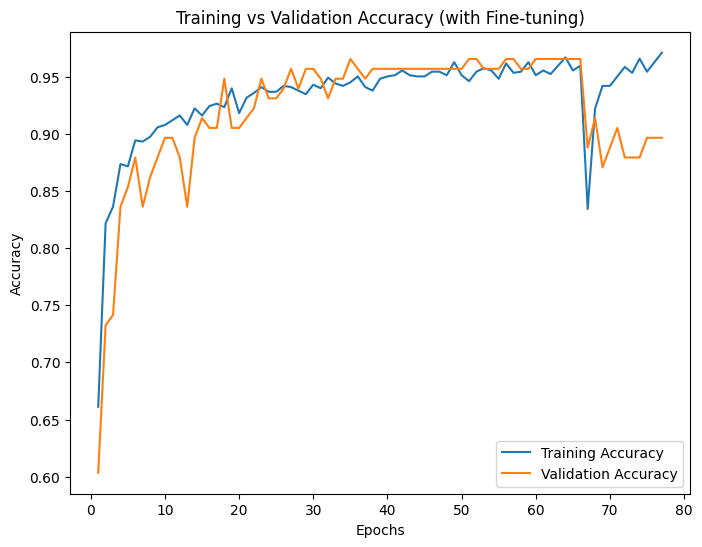

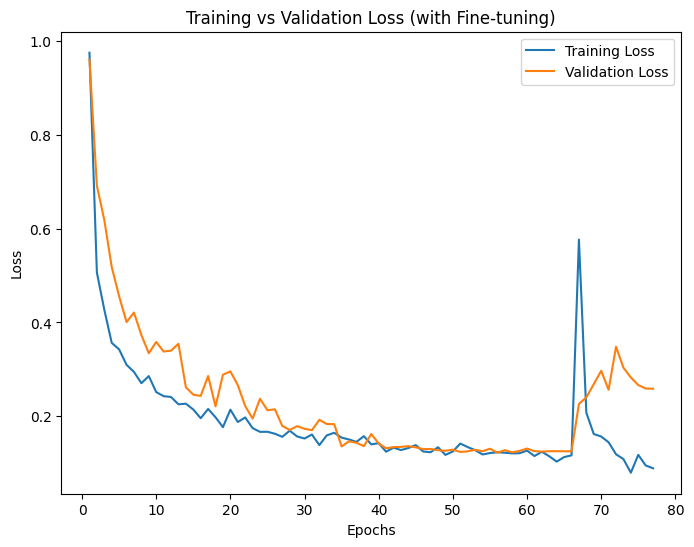

In [ ]:
import matplotlib.pyplot as plt

# Merge history and fine-tuning history
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (with Fine-tuning)')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (with Fine-tuning)')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/Dataset/best_model.h5')

In [ ]:
from google.colab import files
files.download('/content/drive/Dataset/best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving Screenshot 2025-12-28 170002.png to Screenshot 2025-12-28 170002.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


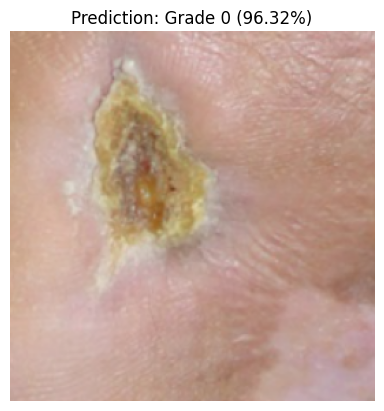

Correctly classified


In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

true_class_name = "Grade 0"  # change based on the image you uploaded
true_class_id = class_names.index(true_class_name)


# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
# Predict
pred = best_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

if class_id == true_class_id:
    print("Correctly classified")
else:
    print("Misclassified")



In [ ]:
# Step 1: Upload the image
from google.colab import files
uploaded = files.upload()  # This will open a file picker

# Get the uploaded file path
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess the uploaded image
import cv2
import numpy as np

# Read the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to your model's expected input size (replace 224 with your size)
img_resized = cv2.resize(img, (224, 224))

# Normalize if your model was trained with normalized images
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# input_array is now ready for Grad-CAM


Saving Screenshot 2025-12-28 170002.png to Screenshot 2025-12-28 170002 (4).png


Last convolutional layer: expanded_conv_project_BN


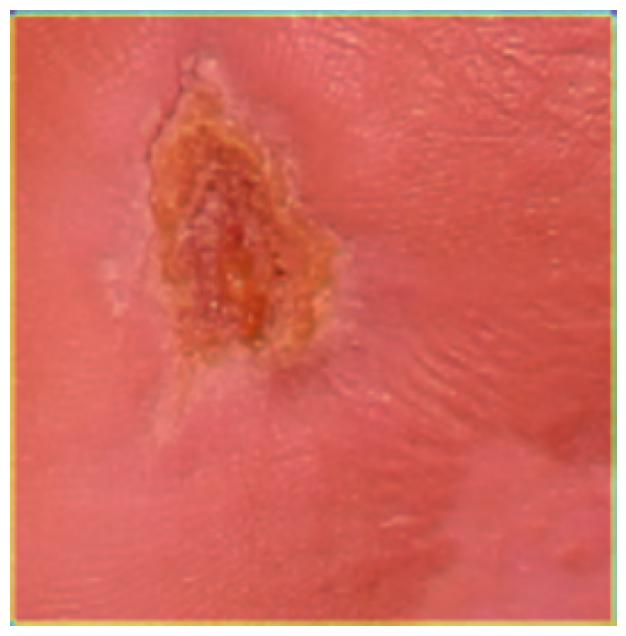

Grad-CAM saved as gradcam_output.png


In [ ]:
# Step 1: Load model
from tensorflow import keras
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Step 2: Load and preprocess uploaded image
import cv2
import numpy as np
#img_path = "Screenshot 2025-12-28 170002 (1).png"  # your uploaded file
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))  # replace 224 with your model input size
input_array = np.expand_dims(img_resized / 255.0, axis=0)  # normalize if needed

# Step 3: Identify last convolutional layer
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break
print("Last convolutional layer:", last_conv_layer_name)

# Step 4: Grad-CAM heatmap generation
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap from 0 to 1 for color mapping
    heatmap = heatmap - tf.reduce_min(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name)

# Step 5: Overlay heatmap on original image with clear blue → red gradient
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Jet: blue=low, red=high
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Step 6: Display Grad-CAM
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

# Optional: save the Grad-CAM image
cv2.imwrite("gradcam_output.png", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
print("Grad-CAM saved as gradcam_output.png")



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

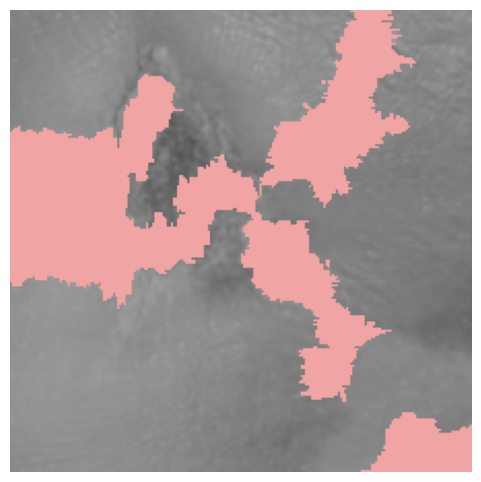

LIME overlay saved as lime_output.png


In [ ]:
# Step 1: Install LIME
!pip install lime

# Step 2: Load model and image
from tensorflow import keras
import cv2
import numpy as np

model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Load uploaded image

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# Step 3: LIME setup
from lime import lime_image
from skimage.segmentation import slic

explainer = lime_image.LimeImageExplainer()

# Define prediction function for LIME
def predict_fn(images):
    images = np.array(images) / 255.0  # normalize
    return model.predict(images)

# Step 4: Generate explanation
explanation = explainer.explain_instance(
    img_resized,                   # original image
    predict_fn,                    # prediction function
    top_labels=1,                  # explain top predicted class
    hide_color=0,
    num_samples=1000               # increase for smoother explanation
)

# Step 5: Get image and mask for top class
from skimage.color import label2rgb

top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)
img_boundry = label2rgb(mask, temp, bg_label=0)

# Step 6: Display and save explanation
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()

# Save the LIME overlay
from matplotlib import image as mpimg
mpimg.imsave("lime_output.png", img_boundry)
print("LIME overlay saved as lime_output.png")


Saving Screenshot 2025-12-28 170429.png to Screenshot 2025-12-28 170429 (10).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


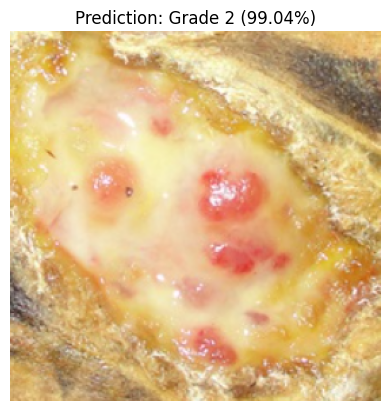

Correctly classified


In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the model
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade 1", "Grade 2", "Grade 3", "Normal" ]
filename = list(uploaded.keys())[0]

true_class_name = "Grade 2"  # change based on the image you uploaded
true_class_id = class_names.index(true_class_name)


# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
# Predict
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

if class_id == true_class_id:
    print("Correctly classified")
else:
    print("Misclassified")



In [ ]:
# Step 1: Upload the image
from google.colab import files
uploaded = files.upload()  # This will open a file picker

# Get the uploaded file path
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess the uploaded image
import cv2
import numpy as np

# Read the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to your model's expected input size (replace 224 with your size)
img_resized = cv2.resize(img, (224, 224))

# Normalize if your model was trained with normalized images
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# input_array is now ready for Grad-CAM


Saving Screenshot 2025-12-28 170429.png to Screenshot 2025-12-28 170429 (11).png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Last convolutional layer: expanded_conv_project_BN


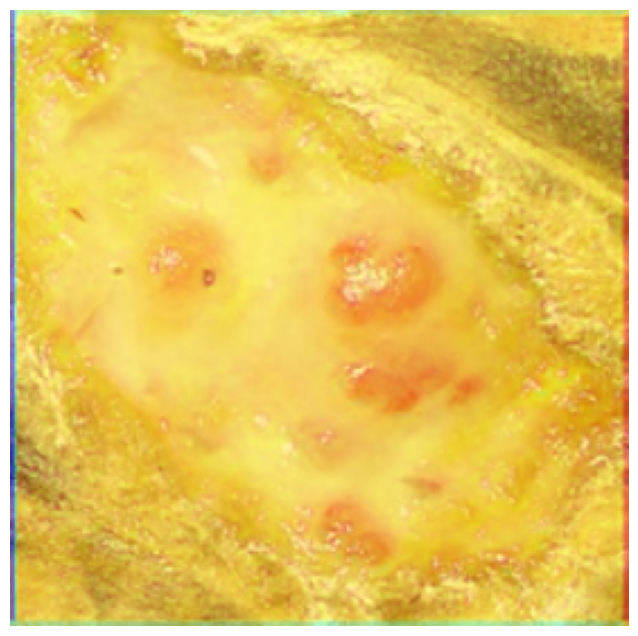

Grad-CAM saved as gradcam_output.png


In [ ]:
# Step 1: Load model
from tensorflow import keras
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Step 2: Load and preprocess uploaded image
import cv2
import numpy as np
#img_path = "Screenshot 2025-12-28 170002 (1).png"  # your uploaded file
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))  # replace 224 with your model input size
input_array = np.expand_dims(img_resized / 255.0, axis=0)  # normalize if needed

# Step 3: Identify last convolutional layer
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break
print("Last convolutional layer:", last_conv_layer_name)

# Step 4: Grad-CAM heatmap generation
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap from 0 to 1 for color mapping
    heatmap = heatmap - tf.reduce_min(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name)

# Step 5: Overlay heatmap on original image with clear blue → red gradient
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Jet: blue=low, red=high
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Step 6: Display Grad-CAM
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

# Optional: save the Grad-CAM image
cv2.imwrite("gradcam_output.png", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
print("Grad-CAM saved as gradcam_output.png")



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

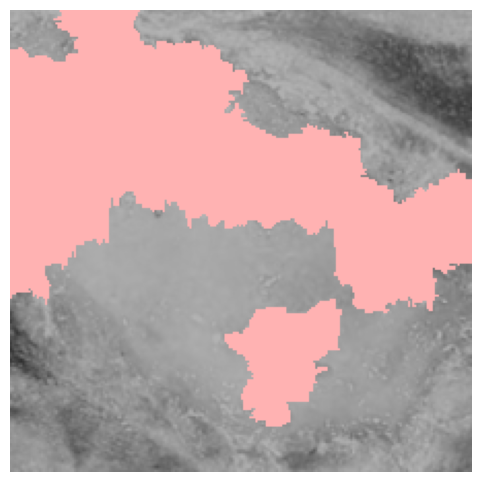

LIME overlay saved as lime_output.png


In [ ]:
# Step 1: Install LIME
!pip install lime

# Step 2: Load model and image
from tensorflow import keras
import cv2
import numpy as np

model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Load uploaded image

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# Step 3: LIME setup
from lime import lime_image
from skimage.segmentation import slic

explainer = lime_image.LimeImageExplainer()

# Define prediction function for LIME
def predict_fn(images):
    images = np.array(images) / 255.0  # normalize
    return model.predict(images)

# Step 4: Generate explanation
explanation = explainer.explain_instance(
    img_resized,                   # original image
    predict_fn,                    # prediction function
    top_labels=1,                  # explain top predicted class
    hide_color=0,
    num_samples=1000               # increase for smoother explanation
)

# Step 5: Get image and mask for top class
from skimage.color import label2rgb

top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)
img_boundry = label2rgb(mask, temp, bg_label=0)

# Step 6: Display and save explanation
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()

# Save the LIME overlay
from matplotlib import image as mpimg
mpimg.imsave("lime_output.png", img_boundry)
print("LIME overlay saved as lime_output.png")


Saving Screenshot 2025-12-28 181553.png to Screenshot 2025-12-28 181553.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


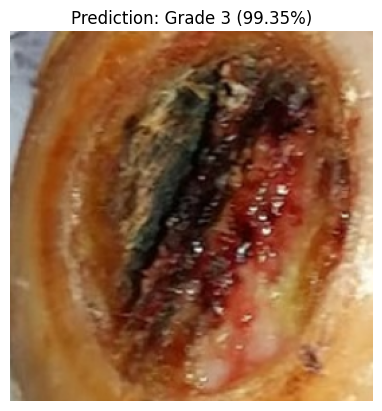

Correctly classified


In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the model
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade 1", "Grade 2", "Grade 3", "Normal" ]
filename = list(uploaded.keys())[0]

true_class_name = "Grade 3"  # change based on the image you uploaded
true_class_id = class_names.index(true_class_name)


# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
# Predict
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

if class_id == true_class_id:
    print("Correctly classified")
else:
    print("Misclassified")



In [ ]:
# Step 1: Upload the image
from google.colab import files
uploaded = files.upload()  # This will open a file picker

# Get the uploaded file path
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess the uploaded image
import cv2
import numpy as np

# Read the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to your model's expected input size (replace 224 with your size)
img_resized = cv2.resize(img, (224, 224))

# Normalize if your model was trained with normalized images
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# input_array is now ready for Grad-CAM


Saving Screenshot 2025-12-28 181553.png to Screenshot 2025-12-28 181553 (1).png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Last convolutional layer: expanded_conv_project_BN


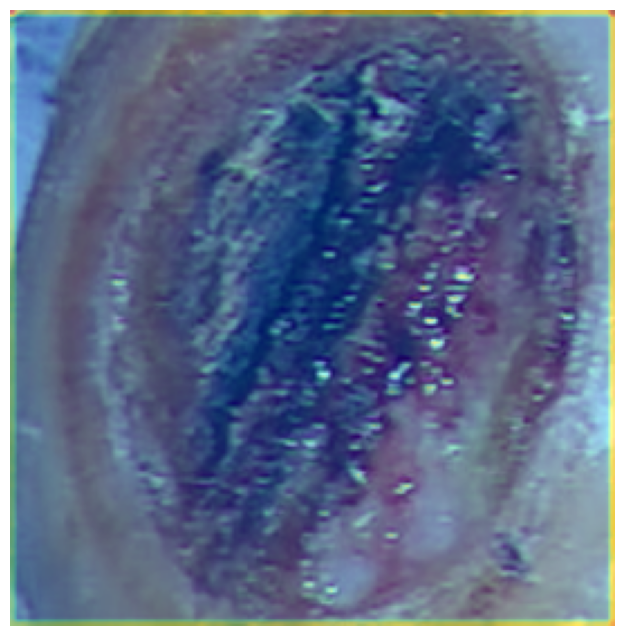

Grad-CAM saved as gradcam_output.png


In [ ]:
# Step 1: Load model
from tensorflow import keras
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Step 2: Load and preprocess uploaded image
import cv2
import numpy as np
#img_path = "Screenshot 2025-12-28 170002 (1).png"  # your uploaded file
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))  # replace 224 with your model input size
input_array = np.expand_dims(img_resized / 255.0, axis=0)  # normalize if needed

# Step 3: Identify last convolutional layer
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break
print("Last convolutional layer:", last_conv_layer_name)

# Step 4: Grad-CAM heatmap generation
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap from 0 to 1 for color mapping
    heatmap = heatmap - tf.reduce_min(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name)

# Step 5: Overlay heatmap on original image with clear blue → red gradient
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Jet: blue=low, red=high
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Step 6: Display Grad-CAM
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

# Optional: save the Grad-CAM image
cv2.imwrite("gradcam_output.png", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
print("Grad-CAM saved as gradcam_output.png")



/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Last convolutional layer: expanded_conv_project_BN


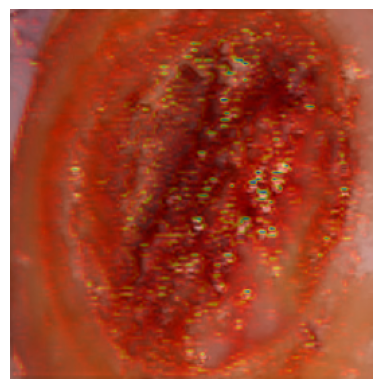

In [ ]:
# Step 1: Load your model
from tensorflow import keras
model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Step 2: Prepare the uploaded image
import cv2
import numpy as np
#img_path = "Screenshot 2025-12-28 170002 (1).png"  # your uploaded file
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))  # replace 224 with your model input size
input_array = np.expand_dims(img_resized / 255.0, axis=0)  # normalize if needed

# Step 3: Identify last conv layer
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break
print("Last convolutional layer:", last_conv_layer_name)

# Step 4: Generate Grad-CAM heatmap
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name)

# Step 5: Overlay heatmap on original image
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Step 6: Display Grad-CAM
import matplotlib.pyplot as plt
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━

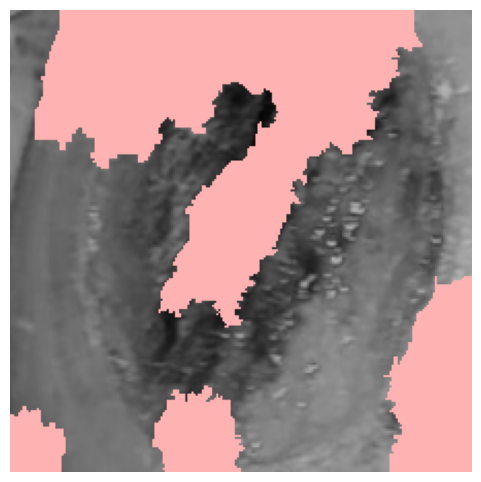

LIME overlay saved as lime_output.png


In [ ]:
# Step 1: Install LIME
!pip install lime

# Step 2: Load model and image
from tensorflow import keras
import cv2
import numpy as np

model = keras.models.load_model('/content/drive/Dataset/best_model.h5')

# Load uploaded image

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))
input_array = np.expand_dims(img_resized / 255.0, axis=0)

# Step 3: LIME setup
from lime import lime_image
from skimage.segmentation import slic

explainer = lime_image.LimeImageExplainer()

# Define prediction function for LIME
def predict_fn(images):
    images = np.array(images) / 255.0  # normalize
    return model.predict(images)

# Step 4: Generate explanation
explanation = explainer.explain_instance(
    img_resized,                   # original image
    predict_fn,                    # prediction function
    top_labels=1,                  # explain top predicted class
    hide_color=0,
    num_samples=1000               # increase for smoother explanation
)

# Step 5: Get image and mask for top class
from skimage.color import label2rgb

top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)
img_boundry = label2rgb(mask, temp, bg_label=0)

# Step 6: Display and save explanation
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()

# Save the LIME overlay
from matplotlib import image as mpimg
mpimg.imsave("lime_output.png", img_boundry)
print("LIME overlay saved as lime_output.png")
